In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)


%matplotlib inline

In [2]:
num_chains = 4
device = "cpu"

numpyro.set_platform(device)
numpyro.set_host_device_count(num_chains)

In [3]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        obs=Y,
    )


# helper function for doing hmc inference
def run_inference(model, args, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if args.init_strategy == "value":
        init_strategy = init_to_value(
            values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
        )
    elif args.init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif args.init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif args.init_strategy == "sample":
        init_strategy = init_to_sample()
    elif args.init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=num_chains,
        thinning=args.thinning,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
        rng_key, X_test.shape[:1]
    )
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y))
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean, mean + sigma_noise


# create artificial regression dataset
def get_data(N=30, sigma_obs=0.15, N_test=400):
    np.random.seed(0)
    X = jnp.linspace(-1, 1, N)
    Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    Y += sigma_obs * np.random.randn(N)
    Y -= jnp.mean(Y)
    Y /= jnp.std(Y)

    assert X.shape == (N,)
    assert Y.shape == (N,)

    X_test = jnp.linspace(-1.3, 1.3, N_test)

    return X, Y, X_test


In [4]:
class DefaultArgs:
    num_samples = 4000
    num_warmup = 1000
    thinning = 2
    num_data = 25
    num_chains = num_chains
    device = device  # choices = ["cpu", "gpu"]
    init_strategy = "median" # choices=["median", "feasible", "value", "uniform", "sample"]

In [5]:
#     parser = argparse.ArgumentParser(description="Gaussian Process example")
#     parser.add_argument("-n", "--num-samples", nargs="?", default=1000, type=int)
#     parser.add_argument("--num-warmup", nargs="?", default=1000, type=int)
#     parser.add_argument("--num-chains", nargs="?", default=1, type=int)
#     parser.add_argument("--thinning", nargs="?", default=2, type=int)
#     parser.add_argument("--num-data", nargs="?", default=25, type=int)
#     parser.add_argument("--device", default="cpu", type=str, help='use "cpu" or "gpu".')
#     parser.add_argument(
#         "--init-strategy",
#         default="median",
#         type=str,
#         choices=["median", "feasible", "value", "uniform", "sample"],
#     )
#     args = parser.parse_args()

In [6]:
args = DefaultArgs()

## Testing on dummy data

In [7]:
X, Y, X_test = get_data(N=args.num_data)

# do inference
rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y)

# do prediction
vmap_args = (
    jax.random.split(rng_key_predict, samples["kernel_var"].shape[0]),
    samples["kernel_var"],
    samples["kernel_length"],
    samples["kernel_noise"],
)
means, predictions = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, Y, X_test, var, length, noise
    )
)(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.70      0.25      0.65      0.34      1.03   5635.87      1.00
   kernel_noise      0.06      0.02      0.06      0.03      0.09   6661.59      1.00
     kernel_var      5.01    111.68      1.37      0.18      6.02   5774.66      1.00

Number of divergences: 0

MCMC elapsed time: 4.8476173877716064


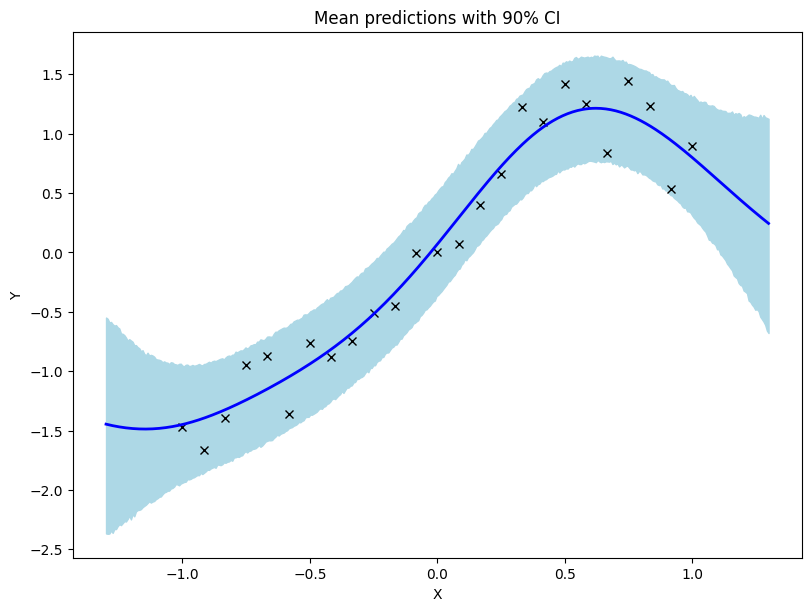

In [8]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "kx")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

plt.show()


## Sleep data

In [9]:
import pandas as pd

In [10]:
args.init_strategy = 'feasible'

In [11]:
full_df = pd.read_csv('data/all_sleep.csv')
full_df['date'] = pd.to_datetime(full_df['date'])

In [12]:
idx_beg, idx_fin = 100, 400
X = full_df.loc[idx_beg:idx_fin, 'date'].index.values
Y = full_df.loc[idx_beg:idx_fin, 'minutes'].values

len_test = 50
X_test = full_df.loc[idx_fin:idx_fin+len_test, 'date'].index.values
Y_test = full_df.loc[idx_fin:idx_fin+len_test, 'minutes'].values

In [ ]:
# do inference
rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y)

# do prediction
vmap_args = (
    jax.random.split(rng_key_predict, samples["kernel_var"].shape[0]),
    samples["kernel_var"],
    samples["kernel_length"],
    samples["kernel_noise"],
)
means, predictions = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, Y, X_test, var, length, noise
    )
)(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# plot training data
ax.plot(X, Y, "kx")
ax.plot(X_test, Y_test, "kx")
# plot 90% confidence level of predictions
ax.fill_between(X_test, percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
ax.plot(X_test, mean_prediction, "blue", ls="solid", lw=2.0)
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")

plt.show()
